In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn
import scipy.stats

import datetime

import astral
from astral.sun import sun

# Checkpoint Report

Policing is a rather mixed affair hinging on a number of different factors with some encounters being relatively short and simple while others are more tense and hostile. What most notably shifts these encounters is how the police either rightfully or wrongfully perceives an individual, suspicion of them doing illegal activity, misdemeanors, or having unconscious bias against individuals that appear to fit their mental description of what a criminal may look like. Naturally racial prejudice is one of the more striking factors to point at when considering how or why encounters between individuals and police officers go differently, but another approach to consider is the social class or perceived social class of the individual. 

# Analysis Based on Service Area Income 

The dataset we are using is the San Diego Police Stops Data from the Stanford Open Policing Dataset. This dataset gives us data from 2015 to 2019 for all police traffic stops in San Diego county. For our analysis we will be focusing on the search rate of drivers in order to determine if police are biased in their searches based off the driver's percieved income level.

The first methods we used to to judge a driver's percived income is using the average income of the service area the police stopped them in. This might not be entirely accurate for say drivers who aren't from a service area they get stopped in, but what is important here is the police's perception of the driver's income level. It should give us a general idea of how police might behave differently in different service areas as well.

In [2]:
open_sd = "ca_san_diego_2020_04_01.csv"
open_data = pd.read_csv(open_sd)

In [ ]:
open_primary = open_data.loc[open_data['subject_race'].isin(['white','black','hispanic'])]
open_primary.drop(open_primary[open_primary['service_area'] == "Unknown"].index, inplace = True)

In [ ]:
vehicle_file = "vehicle_stops_2015_datasd_v1.csv"
v_columns = ['stop_id','stop_cause','subject_race','subject_sex','arrested','service_area',
           'searched','contraband_found','property_seized']
data = pd.read_csv(vehicle_file, usecols = v_columns)

data['arrested'] = data['arrested'].str.lower()
data['searched'] = data['searched'].str.lower()

trimmed = data.dropna(subset = ['subject_race','subject_sex'])
trimmed.drop(trimmed[trimmed['arrested'] == " "].index, inplace = True)
trimmed.drop(trimmed[trimmed['arrested'] == "b"].index, inplace = True)
trimmed.drop(trimmed[trimmed['arrested'] == "m"].index, inplace = True)
trimmed.drop(trimmed[trimmed['searched'] == " "].index, inplace = True)
trimmed.drop(trimmed[trimmed['searched'] == "b"].index, inplace = True)

to_bool = {'y': True, 'n': False}
races = {'W':'white','B':'black',"H":'hispanic'}
trimmed['searched']= trimmed['searched'].map(to_bool)
trimmed['arrested']= trimmed['arrested'].map(to_bool)
trimmed['subject_race']= trimmed['subject_race'].replace(races)

sd_primary = trimmed.loc[trimmed['subject_race'].isin(['white','black','hispanic'])]
sd_search = sd_primary.loc[sd_primary['searched']== True]
sd_arrest = sd_primary.loc[sd_primary['arrested']==True]

In [5]:
census_file = "nhgis0006_ds239_20185_blck_grp.csv"

use = ['GISJOIN','COUNTY','AJZ8E001']
census_df = pd.read_csv(census_file, usecols = use)
census_df = census_df.loc[census_df['COUNTY'] == 'San Diego County']

In [ ]:
url = "CA_block_2010.shx"
census_gdf = geopandas.read_file(url)
census_shape = census_gdf[['GISJOIN','geometry']]

census_shape['GISJOIN'] = census_shape['GISJOIN'].str.slice(stop = 15)

census_joined = census_shape.merge(census_df, on = 'GISJOIN')
census_joined = census_joined.to_crs(epsg = 2230)

In [7]:
pd_beats ="pd_beats_datasd.shx"
gdf = geopandas.read_file(pd_beats)

service = gdf[['serv','geometry']]
service = service.dissolve(by ='serv',aggfunc ='sum',as_index = False)
service = service.rename({'serv':'service_area'},axis='columns')

In [8]:
test = census_joined.sjoin(service, how = 'inner')
overlayed = geopandas.overlay(test,service)

test3 = overlayed.dissolve(by='service_area_2', aggfunc='mean', as_index = False)
income = test3[['service_area_2','geometry','AJZ8E001']]

In [9]:
def totals(full_data, search_column, arrest_column):
    search_data = full_data.loc[full_data[search_column]== True]
    arrest_data = full_data.loc[full_data[arrest_column]==True]
    
    stops = len(full_data)
    searches = len(search_data)
    search_prop = 100*(searches/stops)
    arrests = len(arrest_data)
    arrest_prop = 100*(arrests/stops)
    return [searches,search_prop,arrests,arrest_prop,stops]

In [10]:
service_areas = ['110', '120', '130', '230', '240', '310', '320',
                 '430', '440', '510', '520','530','610','620',
                 '630','710','720','810', '820','830', '930']
by_area = []

columns = []

for x in service_areas:
    #sub_area_sd = trimmed.loc[trimmed['service_area'] == x]
    sub_area_open = open_data.loc[open_data['service_area'] == x]
    
    by_area.append(totals(sub_area_open,'search_conducted','arrest_made'))

In [11]:
columns = ['searched','searched %','arrested','arrested %','stopped']
by_area_df = pd.DataFrame(by_area,columns = columns )
by_area_df['service_area'] = service_areas

In [ ]:
income['service_area'] = income['service_area_2'].astype(str)

In [13]:
joined = income.merge(by_area_df, on = 'service_area')


In order to get the average income of each service area here we used income data from the 2010 US census. Then we geospacially joined the service areas and the census tracts and got the average of all census tracts within each service area to get the average income of each service area.

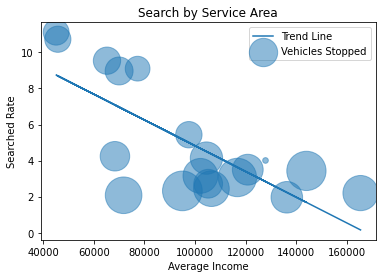

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig0 = joined.plot.scatter(x = 'AJZ8E001', y = 'searched %', s=joined['stopped']/20, alpha=0.5, ax = axes)
m, b = np.polyfit(joined['AJZ8E001'], joined['searched %'], 1)

#add linear regression line to scatterplot 
plt.plot(joined['AJZ8E001'], m*(joined['AJZ8E001'])+b)

fig0.set_title('Search by Service Area')

fig0.set_xlabel('Average Income')
fig0.set_ylabel('Searched Rate')

axes.legend(['Trend Line','Vehicles Stopped'])

Here we have each Service Area represented as a bubble and we can see an inverse relationship between the average income of the service area and the rate that drivers are searched. 

There may be two outliers below the curve at around 70k, but looking at it geospacially it can be more easily explained.

(6238759.659783215, 6366830.753605561, 1764981.7294078567, 1996549.6914567687)

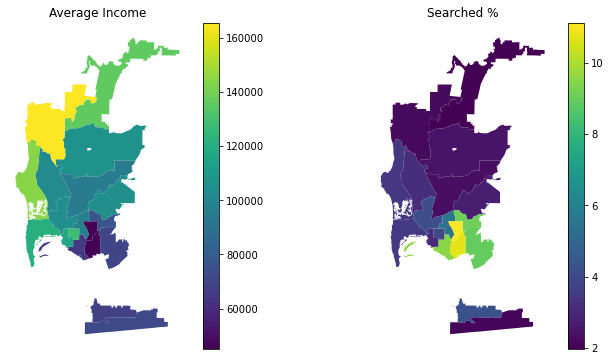

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_figwidth(12)
fig.set_figheight(6)


fig0 = joined.plot(column = 'AJZ8E001', legend = True, ax = axes[0])

fig1 = joined.plot(column = 'searched %', legend = True, ax = axes[1])

#fig2 = joined.plot(column = 'stopped', legend = True, ax = axes[2])

fig0.set_title('Average Income')
fig1.set_title('Searched %')
#fig2.set_title('Stopped')
axes[0].axis('off')
axes[1].axis('off')
#axes[2].axis('off')

In these geospacial plots, we can see the service areas with the lowest average income near the bottom right of San Diego county. And we see the 5 areas with the highest number of searches also in that area clustered together. 

The two outliers from before are the ones at the border of San Diego county, where different types of policing may take place for drivers crossing the border.

This could also point to those 5 clusered Service Areas being more heavily profiled.

In [18]:
san = astral.LocationInfo(name='San Diego', region='CA, USA', timezone='America/Los_Angeles',
                   latitude=32.7157, longitude=-117.1611)

In [19]:
def veil_data(dataset,time_column,date_column):
    
    primary = dataset.copy()
    primary['timestamp'] = pd.to_datetime(pd.to_datetime(primary[time_column]),format= '%H:%M',
                                          errors = "coerce").dt.time
    primary.drop(primary[primary['timestamp'].isnull()].index, inplace = True)
    

    primary['date'] = pd.to_datetime(primary[date_column]).dt.date
    
    sundown = []
    
    for x in primary['date']:
        sundown.append(sun(san.observer, x, 
            tzinfo=san.timezone)['dusk'].strftime('%H:%M'))

    primary['sundown'] = sundown
    primary['sundown'] =  pd.to_datetime(primary['sundown'])

    dark = primary['sundown'] + datetime.timedelta(minutes=60)
    light = primary['sundown'] - datetime.timedelta(minutes=60)
    primary['dark'] = pd.to_datetime(dark,format= '%H:%M').dt.time
    primary['light'] = pd.to_datetime(light,format= '%H:%M').dt.time

    primary = primary.loc[primary['timestamp'] >= primary['light']]
    primary = primary.loc[primary['timestamp'] <= primary['dark']]

    primary['twilight'] = (primary['timestamp'] <= 
                        (pd.to_datetime(primary['sundown'],format= '%H:%M').dt.time)).astype(int)

    light = primary.loc[primary['twilight'] == 1]
    dark = primary.loc[primary['twilight'] == 0]
    return (light,dark)

In [20]:
test = veil_data(open_primary,'time','date')

In [21]:
service_areas = ['110', '120', '130', '230', '240', '310', '320',
                 '430', '440', '510', '520','530','610','620',
                 '630','710','720','810', '820','830', '930']
by_area_light = []
by_area_dark = []

columns = []

for x in service_areas:
    #sub_area_sd = trimmed.loc[trimmed['service_area'] == x]
    sub_area_open = test[0].loc[test[0]['service_area'] == x]
    if len(sub_area_open) == 0:
        by_area_light.append([0,0,0,0,0])
    else:
        by_area_light.append(totals(sub_area_open,'search_conducted','arrest_made'))

for x in service_areas:
    #sub_area_sd = trimmed.loc[trimmed['service_area'] == x]
    sub_area_open = test[1].loc[test[1]['service_area'] == x]
    if len(sub_area_open) == 0:
        by_area_dark.append([0,0,0,0,0])
    else:
        by_area_dark.append(totals(sub_area_open,'search_conducted','arrest_made'))

In [22]:
columns = ['searched','searched %','arrested','arrested %','stopped']
by_area_df_light = pd.DataFrame(by_area_light,columns = columns)
by_area_df_light['service_area'] = service_areas

by_area_df_dark = pd.DataFrame(by_area_dark,columns = columns)
by_area_df_dark['service_area'] = service_areas

In [23]:
joined_light = income.merge(by_area_df_light, on = 'service_area')
joined_dark = income.merge(by_area_df_dark, on = 'service_area')

# Veil of Darkness by Service Area Income

Using service area income like in the last section, a technique known as the veil of darkness will be employed.

This technique limits the range of searches to all searches from an hour before twilight to an hour after twilight. The thought here is that police cannot as easily racially profile and stop minority drivers after twilight since they would not be able to see the color of the driver's skin. 

By adding the income of the service areas, we may be able to see a pattern emerge in where this racial profiling is taking place. Naturally since lower income service areas have larger populations of African American and Hispanic residents, we'd expect them to have higher amounts of profiling. But what we also want to look at is whether or not racial profiling is also notable higher income neighborhoods.

Another thing we can look at here is how different service areas may be treated after dark, where police might deem a car more suspicious for driving after twilight.

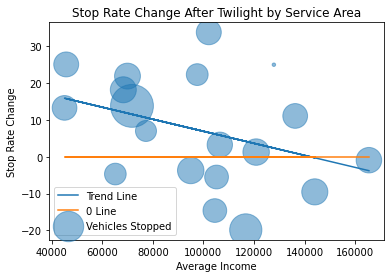

In [24]:
joined_light['change'] = ((joined_light['stopped'] - joined_dark['stopped'])/joined_light['stopped']) * 100

fig, axes = plt.subplots(nrows=1, ncols=1)
fig0 = joined_light.plot.scatter(x = 'AJZ8E001', y = 'change', s=joined_light['stopped'], alpha=0.5, ax = axes)
m, b = np.polyfit(joined_light['AJZ8E001'], joined_light['change'], 1)

#add linear regression line to scatterplot 
plt.plot(joined_dark['AJZ8E001'], m*(joined_dark['AJZ8E001'])+b)
plt.plot(joined_dark['AJZ8E001'], 0*(joined_dark['AJZ8E001']))


fig0.set_title('Stop Rate Change After Twilight by Service Area')

fig0.set_xlabel('Average Income')
fig0.set_ylabel('Stop Rate Change')

axes.legend(['Trend Line', "0 Line", 'Vehicles Stopped'])

This graph shows the percent change from the hour before twilight and after twilight. The orange line there is at 0 percent and what would happen if there were 0 change between before and after twilight.

What we see here is that lower income service area get stopped notably more after twilight, while higher income service areas get stopped less often.

In [25]:
service_bucket = {'<80k':['830','440','510','720','430','710','820'],
                  '80-110k':['310','810','620','320','240'],
                 '>110k':['520','610','530','230','120','930']}

In [26]:
joined_light['income_bucket'] = pd.cut(joined_light['AJZ8E001'], 3, labels = ['lowest','medium','highest'])

In [27]:
bucket_primary = open_primary.merge(joined_light[['service_area','income_bucket']],on = 'service_area')

In [28]:
lowest_primary = bucket_primary.loc[bucket_primary['income_bucket']== 'lowest']
middle_primary = bucket_primary.loc[bucket_primary['income_bucket']== 'medium']
highest_primary = bucket_primary.loc[bucket_primary['income_bucket']== 'highest']

In [29]:
test_low = veil_data(lowest_primary,'time','date')
test_med = veil_data(middle_primary,'time','date')
test_high = veil_data(highest_primary,'time','date')

In [56]:
def veil_plots(light,dark,subject_race_column,arrested_column,race_list, lim = 1, income = 'low'):
    fig, axes = plt.subplots(nrows=1, ncols=2)

    fig.set_figwidth(10)

    totals_light = (light[[subject_race_column,arrested_column]]).groupby([subject_race_column],as_index = False).count()
    totals_light[arrested_column] = (totals_light[arrested_column])/sum(totals_light[arrested_column])
    totals_light = totals_light.loc[totals_light[subject_race_column].isin(race_list)]
    totals_light = totals_light.rename({arrested_column:'stops'},axis='columns')
    light_plot = seaborn.barplot(data = totals_light, x =subject_race_column, y = 'stops', ax = axes[0])
    light_plot.set_ylim(0, lim)
    light_plot.set_title(income + ' Hour Before Sundown')

    totals_dark = (dark[[subject_race_column,arrested_column]]).groupby([subject_race_column],as_index = False).count()
    totals_dark[arrested_column] = (totals_dark[arrested_column])/sum(totals_dark[arrested_column])
    totals_dark = totals_dark.loc[totals_dark[subject_race_column].isin(race_list)]
    totals_dark = totals_dark.rename({arrested_column:'stops'},axis='columns')
    dark_plot = seaborn.barplot(data = totals_dark, x =subject_race_column, y = 'stops', ax = axes[1])
    dark_plot.set_ylim(0, lim)
    dark_plot.set_title(income + ' Hour After Sundown')
    return totals_dark

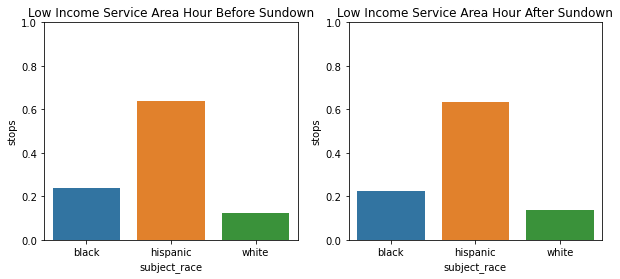

In [58]:
races = ['white','black','hispanic']
t = veil_plots(test_low[0],test_low[1], 'subject_race','arrest_made', races,1, "Low Income Service Area")

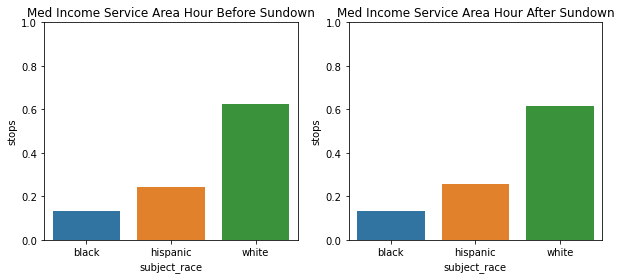

In [59]:
t = veil_plots(test_med[0],test_med[1], 'subject_race','arrest_made', races,1, "Med Income Service Area")

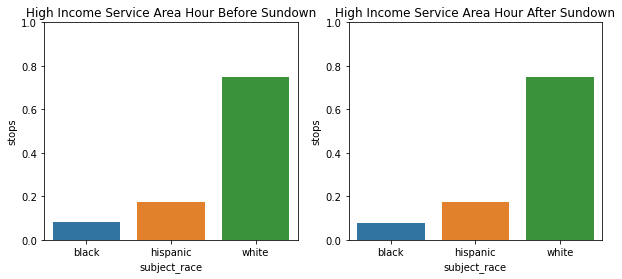

In [60]:
t = veil_plots(test_high[0],test_high[1], 'subject_race','arrest_made', races,1, "High Income Service Area")

After grouping the service areas into three categories based on income for low, medium and high income, there seems to be little evidence of racial profiling shown through the veil of darkness technique.

However seeing that there is still a notable change in stop rate before and after twilight, the lower income service areas may be more systematically or indirectly targeted based on the average income of the service area.

# Car Price as Income

In order to further our analysis on police stop data, we wanted to include the price of the car stopped to see if there is a socioeconomic factor in police stop, search and arrest rates. From the Stanford Open Police Project, we found a dataset that includes stop data from San Antonio, Texas, with the make, model and year of the car stopped. I wanted to join this onto a dataset to get the price of the car that was stopped. We found two potential datasets that we could join on, a Kaggle dataset, and a Kelly Blue Book (KBB) dataset. However, several potential problems soon arose: the Texas data abbreviated the make and model of the car. For example, a 2015 Toyota Tundra would be 2015 TOY TUND, whereas the other datasets (kaggle and KBB) both used full names. After some consideration, I elected to go with the KBB data, as it was more complete and included more makes and models of cars. The Texas data includes over 20,000 unique year, make and model cars, and the KBB data provides price data for 17,651 unique year make and model cars. I first tried to use difflib to find closest matches directly between these two datasets, but the code was too inefficient and would take many hours to run. Difflib.get_close_matches() returns a “close enough” match based on the number of similarities it can find between a string and a list of comparison strings. 

To work around the large datasets and runtime of get_close_matches, I first made a dictionary that matches the car make as listed in the texas dataset with the car makes in the KBB dataset by hand. The resulting dictionary had 44 matches. I then made an empty dictionary to hold the price of each make and model. Then, for each car in the Kelly Blue Book data, I found the closest match in the texas data to the full car name, (year, make, model), then set that closest match to be a key in the empty dictionary. I then set the value for that key to be the price from the KBB data. I converted that dictionary into a dataset, cleaned it and gave it column names, then merged it onto the texas dataset to get a dataset that has 65217 rows. Overall, the quality of the join is decent, but leaves much to be desired. After cleaning the Texas dataset, it had 873,113 rows with car data in them, but the join reduced that to just 65,217 rows, a reduction of 92%. Even though there is still plenty of data to be analyzed, it shows that this join method is far from optimal, and is something that can be improved upon in the future. A working hypothesis on why so much data could not be matched is due to a mismatch between KBB and Texas datasets, with KBB not having some cars mentioned in the Texas Dataset. It could also be due to the messy nature of the Texas Dataset, with some cars having wildly incorrect ages, making it impossible to find a similar match with KBB data. 


# Feedback Loop Simulation

When we are preparing the Stanford Open Policing Data, we try to rule out columns that we
think are not features that a police officer can come up with at the time of the stop if they wish to
use our model. We decided to stick with 9 features, all of which are reasonable in that a police
officer is able to pull up all the information necessary to input into the model. For example, we
have the service area, a police officer should know which area they are currently assigned to, we
have race/sex/age that can be pulled up from the license plate (only correct if the person driving
is who the car is registered to), and day of the week.
While cleaning and preparing our data, we are also trying to make our label/prediction much
better. For example if our initial data had been a search but there was no contraband found then
in our newly created label we would have a 0 meaning there should not have been a search in the
first place.

So how our model works is that it takes in the first n months (lets use 3 in this example) and
trains the model on it. Then we take the next 3 months (April, May, June) and predict on that.
When we have those predictions we then replace the actual labels with the predicted labels and
we refit the model with April, May, June and the predicted labels and then we take the 3 months
after and do the same until we reach December. We evaluate our model using recall and
precision, as well as accuracy. The current Classifier we are using is LDA, but we will keep
trying out different models to see which works best.

If this model were to be deployed, we would expect police officers to use it if they had someone
stopped and were trying to figure out if they should search them or not. The inputs to the model
would all be available to the officer performing the stop, therefore the model should be able to
give a good prediction of whether or not the officer should search or not.

# Appendix

Original Proposal:

Policing is a rather mixed affair hinging on a number of different factors with some encounters being relatively short and simple while others are more tense and hostile. What most notably shifts these encounters is how the police either rightfully or wrongfully perceives an individual, suspicion of them doing illegal activity, misdemeanors, or having unconscious bias against individuals that appear to fit their mental description of what a criminal may look like. Naturally racial prejudice is one of the more striking factors to point at when considering how or why encounters between individuals and police officers go differently, but another approach to consider is the social class or perceived social class of the individual. 

For police traffic stops and searches, the assumption here is that a police officer is much less likely to ticket or search a person they consider to be an upstanding citizen. They would be much more likely to search a lower class person who they wouldn’t regard as highly. In other words police officers would be less likely to suspect a person of drug or other contraband crimes if they perceive the person to be middle or upper class rather than lower class.

This sort of pattern could also lead to more problems in the future in terms of predictive policing, as police officers are less likely to search upper class citizens, the less of a chance there is for any of their crimes to be caught and the less inclined an algorithm might be to search similar people in the future. Meanwhile, since lower class citizens are the ones being searched more, more crime will be found and the more inclined an algorithm may be to search them.

For this project, in order to investigate bias between social classes we will look at traffic stop data and compare stop and search rates of different neighborhoods and service areas that are more or less well off. Arrest rates here are also important as a hit rate for searches. By separating the data by service area and using census data we can paint a clearer picture of where police traffic stop interactions may be racially biased, but also where the neighborhoods themselves may play a factor in shaping the interactions. Having relatively larger numbers of stops for the populations of the service areas may also point to bias against these neighborhoods.

One of the techniques we are using is the Veil of Darkness, it will further help with our investigation of bias in policing and traffic stops. What is this Veil of Darkness? It is a technique that relies on the idea that police are biased, therefore we would see this bias in daylight stops and not night time stops, since it is easier to tell the race of the person when the sun is out versus when it is not. Thus seeing higher search/arrest rates during the day than night can lead us to believe that there is some bias going on. 

The second aspect of this project is designing and monitoring how feedback loops can occur and how to design or simulate algorithms that can keep them in check. For example, if a predictive policing algorithm is implicitly biased towards stopping minorities or people of color (since it considers them a higher risk), it leads to more arrests and injustice towards those groups. The data would then be reported and feed the bias in the algorithm, creating a feedback loop. To combat this, we will be researching how to avoid bias in data collection, and how to stamp it out in algorithm design to create a fair predictive policing system. If time permits, we will also attempt to create our own, fair policing algorithm that can detect and correct any biases in itself. 
